## Assignment 12: Finalised codebase showcasing all relevant results

# This Notebook
1) loads & aligns gov/IRS/futures panels,
2) builds fly CRD signals (baseline fixed-z + rolling-z + IRS-confirmed z),
3) runs IS backtests for Baseline/R1/R2/R3,
4) produces IS plots + stats + correlation heatmaps,
5) runs OOS backtest for R3 only (signals computed on full history; OOS slice from 2020 onwards),
6) produces OOS plots + stats for R3.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use("default")

# IS & OOS windwos:
IN_SAMPLE_START = pd.Timestamp("2004-01-01")
IN_SAMPLE_END   = pd.Timestamp("2019-12-31") 



ANNUAL_DAYS = 252
DT = 1.0 / ANNUAL_DAYS

H_MONTH = 1
H = H_MONTH / 12.0

ROLL_WIN_6M = 126
MA_WIN = 5

ENTRY_Z = 1.6
EXIT_Z = 0.2

DV01_BUDGET_TOTAL = 100_000
DV01_LIMIT_FLY = 0.25 * DV01_BUDGET_TOTAL
CAPITAL_PER_DV01 = 100.0
MAX_FLY_POSITIONS = 4

# Baseline stale normalisation - just include to show its appalling performance
BASELINE_FIXED_WIN = 2520  # ~10y trading days

xlsx_path = Path("Yield curve arb.xlsx")


In [6]:
CURVE_COLS = {
    "US": ["USG2YR", "USG5YR", "US10GYR", "US30GYR"],
    "DE": ["GDBR2", "GDBR5", "GDBR10", "GDBR30"],
    "UK": ["GUKG2", "GUKG5", "GUKG10", "GUKG30"],
    "IT": ["GBTPGR2", "GBTPGR5", "GBTPGR10", "GBTPGR30"],
    "JP": ["JGBS2", "JGBS5", "JGBS10", "JGBS30"],
    "AU": ["GTAUD2Y", "GTAUD5Y", "GTAUD10Y", "GTAUD30Y"],
    "CA": ["GTCAD2Y", "GTCAD5Y", "GTCAD10Y", "GTCAD30Y"],
}

TENOR_MAP = {
    "USG2YR": 2.0, "USG5YR": 5.0, "US10GYR": 10.0, "US30GYR": 30.0,
    "GDBR2": 2.0, "GDBR5": 5.0, "GDBR10": 10.0, "GDBR30": 30.0,
    "GUKG2": 2.0, "GUKG5": 5.0, "GUKG10": 10.0, "GUKG30": 30.0,
    "GBTPGR2": 2.0, "GBTPGR5": 5.0, "GBTPGR10": 10.0, "GBTPGR30": 30.0,
    "JGBS2": 2.0, "JGBS5": 5.0, "JGBS10": 10.0, "JGBS30": 30.0,
    "GTAUD2Y": 2.0, "GTAUD5Y": 5.0, "GTAUD10Y": 10.0, "GTAUD30Y": 30.0,
    "GTCAD2Y": 2.0, "GTCAD5Y": 5.0, "GTCAD10Y": 10.0, "GTCAD30Y": 30.0,
}

IRS_CURVE_COLS = {
    "US": ["USSW2", "USSW5", "USSW10", "USSW30"],
    "DE": ["EUSA2", "EUSA5", "EUSA10", "EUSA30"],
    "UK": ["BPSW2", "BPSW5", "BPSW10", "BPSW30"],
    "JP": ["JYSW2", "JYSW5", "JYSW10", "JYSW30"],
    "CA": ["CDSW2", "CDSW5", "CDSW10", "CDSW30"],
    "AU": ["ADSW2", "ADSW5", "ADSW10", "ADSW30"],
}

IRS_TENOR_MAP = {
    "USSW2": 2.0, "USSW5": 5.0, "USSW10": 10.0, "USSW30": 30.0,
    "EUSA2": 2.0, "EUSA5": 5.0, "EUSA10": 10.0, "EUSA30": 30.0,
    "BPSW2": 2.0, "BPSW5": 5.0, "BPSW10": 10.0, "BPSW30": 30.0,
    "JYSW2": 2.0, "JYSW5": 5.0, "JYSW10": 10.0, "JYSW30": 30.0,
    "CDSW2": 2.0, "CDSW5": 5.0, "CDSW10": 10.0, "CDSW30": 30.0,
    "ADSW2": 2.0, "ADSW5": 5.0, "ADSW10": 10.0, "ADSW30": 30.0,
}

FLIES = [(2.0, 5.0, 10.0), (5.0, 10.0, 30.0)]

FUT_MAP = {
    "US": {2.0: "TU1 Comdty", 5.0: "FV1 Comdty", 10.0: "TY1 Comdty", 30.0: "US1 Comdty"},
    "DE": {2.0: "DU1 Comdty", 5.0: "OE1 Comdty", 10.0: "RX1 Comdty", 30.0: "UB1 Comdty"},
    "UK": {2.0: "WB1 Comdty", 5.0: "WX1 Comdty", 10.0: "G 1 Comdty", 30.0: "UGL1 Comdty"},
}
CONTRACT_MULT = 1000.0

COST_ROUNDTRIP_BP_COUNTRY = {
    "US": 0.12, "DE": 0.12, "UK": 0.18, "JP": 0.08, "AU": 0.35, "CA": 0.25, "IT": 0.50,
}
FLY_LIQ_MULT = {"2s5s10s": 1.0, "5s10s30s": 1.3}


# Load data - Align the excel to panels etc

In [7]:
def _read_pairs(sheet_name: str, pairs, dayfirst=False, div100=False) -> pd.DataFrame:
    raw = pd.read_excel(xlsx_path, sheet_name=sheet_name)
    series_list = []
    for date_col, val_col in pairs:
        df = raw[[date_col, val_col]].copy()
        df.columns = ["Date", val_col]
        df = df.dropna(how="all")
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce", dayfirst=dayfirst)
        df = df.dropna(subset=["Date"]).set_index("Date").sort_index()
        df = df[~df.index.duplicated(keep="last")]
        series_list.append(df)
    out = pd.concat(series_list, axis=1).sort_index().ffill()
    return (out / 100.0) if div100 else out


def load_sovereign_yields() -> pd.DataFrame:
    yc_pairs = [
        ("Date", "USG2YR"), ("Date.1", "USG5YR"), ("Date.2", "US10GYR"), ("Date.3", "US30GYR"),
        ("Date.4", "GDBR2"), ("Date.5", "GDBR5"), ("Date.6", "GDBR10"), ("Date.7", "GDBR30"),
        ("Date.8", "GUKG2"), ("Date.9", "GUKG5"), ("Date.10", "GUKG10"), ("Date.11", "GUKG30"),
        ("Date.12", "GBTPGR2"), ("Date.13", "GBTPGR5"), ("Date.14", "GBTPGR10"), ("Date.15", "GBTPGR30"),
        ("Date.16", "JGBS2"), ("Date.17", "JGBS5"), ("Date.18", "JGBS10"), ("Date.19", "JGBS30"),
        ("Date.20", "GTAUD2Y"), ("Date.21", "GTAUD5Y"), ("Date.22", "GTAUD10Y"), ("Date.23", "GTAUD30Y"),
        ("Date.24", "GTCAD2Y"), ("Date.25", "GTCAD5Y"), ("Date.26", "GTCAD10Y"), ("Date.27", "GTCAD30Y"),
    ]
    return _read_pairs("Yield Signals", yc_pairs, dayfirst=False, div100=True)


def load_futures_prices() -> pd.DataFrame:
    fut_pairs = [
        ("Date", "TU1 Comdty"), ("Date.1", "FV1 Comdty"), ("Date.2", "TY1 Comdty"), ("Date.3", "US1 Comdty"),
        ("Date.4", "DU1 Comdty"), ("Date.5", "OE1 Comdty"), ("Date.6", "RX1 Comdty"), ("Date.7", "UB1 Comdty"),
        ("Date.8", "WB1 Comdty"), ("Date.9", "WX1 Comdty"), ("Date.10", "G 1 Comdty"), ("Date.11", "UGL1 Comdty"),
    ]
    return _read_pairs("Futs", fut_pairs, dayfirst=True, div100=False)


def load_irs_yields() -> pd.DataFrame:
    irs_pairs = [
        ("Date", "USSW2"), ("Date.1", "USSW5"), ("Date.2", "USSW10"), ("Date.3", "USSW30"),
        ("Date.4", "EUSA2"), ("Date.5", "EUSA5"), ("Date.6", "EUSA10"), ("Date.7", "EUSA30"),
        ("Date.8", "BPSW2"), ("Date.9", "BPSW5"), ("Date.10", "BPSW10"), ("Date.11", "BPSW30"),
        ("Date.12", "JYSW2"), ("Date.13", "JYSW5"), ("Date.14", "JYSW10"), ("Date.15", "JYSW30"),
        ("Date.16", "CDSW2"), ("Date.17", "CDSW5"), ("Date.18", "CDSW10"), ("Date.19", "CDSW30"),
        ("Date.20", "ADSW2"), ("Date.21", "ADSW5"), ("Date.22", "ADSW10"), ("Date.23", "ADSW30"),
    ]
    return _read_pairs("IRS", irs_pairs, dayfirst=True, div100=True)


def build_curve_df_for_country(panel: pd.DataFrame, country: str, cols_map: dict, tenor_map: dict) -> pd.DataFrame:
    cols = cols_map[country]
    sub = panel[cols].copy()
    sub.columns = [tenor_map[c] for c in cols]
    return sub[sorted(sub.columns)]


# Loading data, and enforce the in-sample 

In [ ]:
yields = load_sovereign_yields()
futures_px = load_futures_prices()
irs = load_irs_yields()

curve_by_cty = {cty: build_curve_df_for_country(yields, cty, CURVE_COLS, TENOR_MAP) for cty in CURVE_COLS}
irs_curve_by_cty = {cty: build_curve_df_for_country(irs, cty, IRS_CURVE_COLS, IRS_TENOR_MAP) for cty in IRS_CURVE_COLS}

# aligning dates across gov + futures + IRS
common = None
for cty, df in curve_by_cty.items():
    common = df.index if common is None else common.intersection(df.index)
common = common.intersection(futures_px.index)
for cty, df in irs_curve_by_cty.items():
    common = common.intersection(df.index)
common = common.sort_values()

for cty in curve_by_cty:
    curve_by_cty[cty] = curve_by_cty[cty].reindex(common).ffill()
for cty in irs_curve_by_cty:
    irs_curve_by_cty[cty] = irs_curve_by_cty[cty].reindex(common).ffill()
futures_px = futures_px.reindex(common).ffill()

# Esnure the insample
ins_mask = (common >= IN_SAMPLE_START) & (common <= IN_SAMPLE_END)
ins_dates = common[ins_mask]

for cty in curve_by_cty:
    curve_by_cty[cty] = curve_by_cty[cty].reindex(ins_dates).ffill()
for cty in irs_curve_by_cty:
    irs_curve_by_cty[cty] = irs_curve_by_cty[cty].reindex(ins_dates).ffill()
futures_px = futures_px.reindex(ins_dates).ffill()

print("IN-SAMPLE date range:", ins_dates.min(), "→", ins_dates.max(), "| N =", len(ins_dates))

# rebi9old the rqe objects if missing
needed = ["curve_by_cty", "irs_curve_by_cty", "futures_px", "ins_dates"]
missing = [x for x in needed if x not in globals()]

if missing:
    print("Rebuilding missing objects:", missing)

    # load the raw panels
    yields = load_sovereign_yields()
    futures_px = load_futures_prices()
    irs = load_irs_yields()

    # build countryt curves 
    curve_by_cty = {cty: build_curve_df_for_country(yields, cty, CURVE_COLS, TENOR_MAP) for cty in CURVE_COLS}
    irs_curve_by_cty = {cty: build_curve_df_for_country(irs, cty, IRS_CURVE_COLS, IRS_TENOR_MAP) for cty in IRS_CURVE_COLS}

    # Align dates across gov + futures + IRS
    common = None
    for cty, df in curve_by_cty.items():
        common = df.index if common is None else common.intersection(df.index)
    common = common.intersection(futures_px.index)
    for cty, df in irs_curve_by_cty.items():
        common = common.intersection(df.index)
    common = common.sort_values()

    for cty in curve_by_cty:
        curve_by_cty[cty] = curve_by_cty[cty].reindex(common).ffill()
    for cty in irs_curve_by_cty:
        irs_curve_by_cty[cty] = irs_curve_by_cty[cty].reindex(common).ffill()
    futures_px = futures_px.reindex(common).ffill()

    # Enforce In-Sample - please dont break it again
    ins_mask = (common >= IN_SAMPLE_START) & (common <= IN_SAMPLE_END)
    ins_dates = common[ins_mask]

    for cty in curve_by_cty:
        curve_by_cty[cty] = curve_by_cty[cty].reindex(ins_dates).ffill()
    for cty in irs_curve_by_cty:
        irs_curve_by_cty[cty] = irs_curve_by_cty[cty].reindex(ins_dates).ffill()
    futures_px = futures_px.reindex(ins_dates).ffill()

    print("IN-SAMPLE date range:", ins_dates.min(), "→", ins_dates.max(), "| N =", len(ins_dates))
else:
    print("All required objects already exist. Proceeding...")


IN-SAMPLE date range: 2005-01-03 00:00:00 → 2019-12-31 00:00:00 | N = 3876
All required objects already exist. Proceeding...


# Helpers for bond math and the signal engine (baseline and the refinement)

- including in the baseline for this final?

In [ ]:
def zero_coupon(y: float, T: float):
    P = np.exp(-y * T)
    dv01 = P * T * 1e-4
    return P, dv01

def interp_yield(curve_row: pd.Series, T: float) -> float:
    xs = curve_row.index.values.astype(float)
    ys = curve_row.values.astype(float)
    o = np.argsort(xs)
    xs, ys = xs[o], ys[o]
    return float(np.interp(T, xs, ys))

def roll_down_dy(curve_row: pd.Series, T: float, H: float) -> float:
    if T - H <= 0:
        return 0.0
    return interp_yield(curve_row, T - H) - interp_yield(curve_row, T)

def crd_single_leg(curve_row: pd.Series, T: float, H: float, fund_rate: float):
    y = interp_yield(curve_row, T)
    P, dv01 = zero_coupon(y, T)
    dy_roll = roll_down_dy(curve_row, T, H)
    roll_pnl = -dv01 * (dy_roll * 1e4)
    carry = (y - fund_rate) * H * P
    crd_ret = (roll_pnl + carry) / P
    return crd_ret, P, dv01

def fly_weight_self_financing_dv01_neutral(dv01_L, dv01_B, dv01_R):
    A = np.array([[dv01_L, dv01_R],
                  [1.0,    1.0]])
    b = np.array([-dv01_B, -1.0])
    wL, wR = np.linalg.solve(A, b)
    return float(wL), 1.0, float(wR)

def compute_signal_for_fly(curve_df: pd.DataFrame, tenors: tuple, H: float,
                           ma_win: int, roll_win: int, fixed_win: int):
    T_L, T_B, T_R = tenors
    rows = []
    for date, curve_row in curve_df.iterrows():
        if curve_row.isna().any():
            rows.append((date, np.nan, np.nan, np.nan, np.nan, np.nan))
            continue
        fund_rate = float(curve_row.loc[2.0]) if 2.0 in curve_row.index else float(curve_row.iloc[0])

        crd_L, _, dv01_L = crd_single_leg(curve_row, T_L, H, fund_rate)
        crd_B, _, dv01_B = crd_single_leg(curve_row, T_B, H, fund_rate)
        crd_R, _, dv01_R = crd_single_leg(curve_row, T_R, H, fund_rate)

        wL, wB, wR = fly_weight_self_financing_dv01_neutral(dv01_L, dv01_B, dv01_R)
        fly_crd = wL * crd_L + wB * crd_B + wR * crd_R
        fly_dv01_abs = abs(dv01_L * wL) + abs(dv01_B * wB) + abs(dv01_R * wR)

        rows.append((date, fly_crd, wL, wB, wR, fly_dv01_abs))

    sig = pd.DataFrame(rows, columns=["Date","sig_raw","wL","wB","wR","fly_dv01_abs"]).set_index("Date")

    sig["sig_smooth"] = sig["sig_raw"].rolling(ma_win, min_periods=1).mean()
    roll = sig["sig_smooth"].rolling(roll_win, min_periods=20)
    sig["z_roll"] = (sig["sig_smooth"] - roll.mean()) / roll.std(ddof=1)

    # baseline "stale" z-score: freeze mean/std from early sample window - terrible idea, but included for comparison (the one before broke, cant fix the codebase)
    s = sig["sig_smooth"]
    mu0 = s.rolling(fixed_win, min_periods=fixed_win).mean()
    sd0 = s.rolling(fixed_win, min_periods=fixed_win).std(ddof=1)

    first_mu = mu0.dropna().iloc[0] if len(mu0.dropna()) else np.nan
    first_sd = sd0.dropna().iloc[0] if len(sd0.dropna()) else np.nan

    sig["z_fixed"] = (s - first_mu) / first_sd
    return sig

def build_signals(curve_by_cty: dict, flies: list[tuple]) -> dict:
    sig_by_key = {}
    for cty, cdf in curve_by_cty.items():
        for tenors in flies:
            if not all(t in cdf.columns for t in tenors):
                continue
            fly_name = f"{int(tenors[0])}s{int(tenors[1])}s{int(tenors[2])}s"
            sig_df = compute_signal_for_fly(
                cdf, tenors, H,
                ma_win=MA_WIN, roll_win=ROLL_WIN_6M, fixed_win=BASELINE_FIXED_WIN
            )
            sig_by_key[(cty, fly_name)] = {"tenors": tenors, "sig_df": sig_df}
    return sig_by_key


# Adding the IRS confirmation for the R3 

In [10]:
def apply_irs_confirmation(sig_gov: dict, sig_irs: dict, z_col: str = "z_roll") -> dict:
    for key, obj in sig_gov.items():
        g = obj["sig_df"]

        if key not in sig_irs:
            g["z_irs"] = np.nan
            g["filter_ok"] = True
            g["z_filtered"] = g[z_col]
            continue

        i = sig_irs[key]["sig_df"].reindex(g.index)
        g["z_irs"] = i[z_col]

        z_g = g[z_col]
        z_i = g["z_irs"]

        irs_missing = z_i.isna()
        both_valid = z_g.notna() & z_i.notna()
        same_sign = (np.sign(z_g) * np.sign(z_i) > 0) & both_valid

        g["filter_ok"] = (irs_missing & z_g.notna()) | same_sign
        g["z_filtered"] = np.where(g["filter_ok"], z_g, np.nan)

    return sig_gov


# Building the backtest componenets - accounting for costs and other tx costs

In [ ]:
def zero_price_from_curve(curve_row: pd.Series, T: float) -> float:
    y = interp_yield(curve_row, T)
    P, _ = zero_coupon(y, T)
    return P

def run_portfolio_backtest(curve_by_cty, sig_by_key, futures_px,
                           z_use, universe_keys, max_positions,
                           dv01_limit_fly, entry_z, exit_z,
                           use_futures, use_country_costs,
                           cash_proxy_country="US"):
    CAPITAL_TOTAL = max_positions * dv01_limit_fly * CAPITAL_PER_DV01
    CAP_PER_FLY = dv01_limit_fly * CAPITAL_PER_DV01
    FUT_ENTRY_Z = entry_z + 1.0

    common_dates = None
    for cty, cdf in curve_by_cty.items():
        common_dates = cdf.index if common_dates is None else common_dates.intersection(cdf.index)
    common_dates = common_dates.sort_values()
    if futures_px is not None:
        common_dates = common_dates.intersection(futures_px.index).sort_values()

    positions = {
        key: dict(pos_dir=0, inst_type="none", wL=0.0, wB=0.0, wR=0.0,
                  scale=0.0, prev_curve=None, nL=0.0, nB=0.0, nR=0.0,
                  hold_days=0, trade_pnl=0.0, entry_date=None)
        for key in universe_keys
    }

    portfolio_rows, trade_log = [], []

    for t_idx, date in enumerate(common_dates):
        date_prev = None if t_idx == 0 else common_dates[t_idx - 1]
        daily_pnl_gross, trade_cost_today = 0.0, 0.0

        # We need mark to market for the sharpe later 
        for key, st in positions.items():
            cty, fly_name = key
            curve_today = curve_by_cty[cty].loc[date]
            prev_curve = st["prev_curve"]
            pnl = 0.0

            if st["inst_type"] == "bond" and st["pos_dir"] != 0 and prev_curve is not None and st["scale"] > 0:
                T_L, T_B, T_R = sig_by_key[key]["tenors"]
                wL, wB, wR = st["wL"], st["wB"], st["wR"]

                P_L0 = zero_price_from_curve(prev_curve, T_L)
                P_B0 = zero_price_from_curve(prev_curve, T_B)
                P_R0 = zero_price_from_curve(prev_curve, T_R)

                P_L1 = zero_price_from_curve(curve_today, T_L)
                P_B1 = zero_price_from_curve(curve_today, T_B)
                P_R1 = zero_price_from_curve(curve_today, T_R)

                fly_leg_pnl = wL*(P_L1-P_L0) + wB*(P_B1-P_B0) + wR*(P_R1-P_R0)

                fund_prev = float(prev_curve.iloc[0])
                y_L_prev = interp_yield(prev_curve, T_L)
                y_B_prev = interp_yield(prev_curve, T_B)
                y_R_prev = interp_yield(prev_curve, T_R)

                carry_L = (y_L_prev - fund_prev) * DT * P_L0
                carry_B = (y_B_prev - fund_prev) * DT * P_B0
                carry_R = (y_R_prev - fund_prev) * DT * P_R0
                fly_carry = wL*carry_L + wB*carry_B + wR*carry_R

                pnl = (fly_leg_pnl + fly_carry) * st["scale"] * st["pos_dir"]

            if st["inst_type"] == "fut" and st["pos_dir"] != 0 and futures_px is not None and date_prev is not None:
                if cty in FUT_MAP:
                    T_L, T_B, T_R = sig_by_key[key]["tenors"]
                    tick_L = FUT_MAP[cty].get(T_L)
                    tick_B = FUT_MAP[cty].get(T_B)
                    tick_R = FUT_MAP[cty].get(T_R)
                    if all(t in futures_px.columns for t in [tick_L, tick_B, tick_R]):
                        dPL = futures_px.loc[date, tick_L] - futures_px.loc[date_prev, tick_L]
                        dPB = futures_px.loc[date, tick_B] - futures_px.loc[date_prev, tick_B]
                        dPR = futures_px.loc[date, tick_R] - futures_px.loc[date_prev, tick_R]
                        pnl += CONTRACT_MULT * (st["nL"]*dPL + st["nB"]*dPB + st["nR"]*dPR)

            daily_pnl_gross += pnl
            if st["pos_dir"] != 0:
                st["trade_pnl"] += pnl
            st["prev_curve"] = curve_today

        # Cash proxy
        active = sum(1 for st in positions.values() if st["pos_dir"] != 0)
        cap_used = active * CAP_PER_FLY
        cap_unused = max(CAPITAL_TOTAL - cap_used, 0.0)

        cash_pnl = 0.0
        y2 = curve_by_cty[cash_proxy_country].loc[date, 2.0]
        cash_pnl = cap_unused * y2 * DT
        daily_pnl_gross += cash_pnl

        # Here define the exits 
        for key, st in positions.items():
            if st["pos_dir"] == 0:
                continue
            z = sig_by_key[key]["sig_df"].loc[date, z_use]
            if (not np.isnan(z)) and abs(z) < exit_z:
                cty, fly_name = key
                if use_country_costs:
                    base_rt = COST_ROUNDTRIP_BP_COUNTRY.get(cty, 0.15)
                    mult = FLY_LIQ_MULT.get(fly_name, 1.0)
                    trade_cost_today += (base_rt * mult / 2.0) * dv01_limit_fly

                trade_log.append(dict(
                    country=cty, fly=fly_name,
                    entry_date=st["entry_date"], exit_date=date,
                    holding_days=st["hold_days"], side=st["pos_dir"],
                    pnl=st["trade_pnl"], inst_type=st["inst_type"],
                ))

                st.update(pos_dir=0, inst_type="none", scale=0.0,
                          wL=0.0, wB=0.0, wR=0.0,
                          nL=0.0, nB=0.0, nR=0.0,
                          hold_days=0, trade_pnl=0.0, entry_date=None)

        # --- Entries (top-|z| up to capacity) ---
        active = sum(1 for st in positions.values() if st["pos_dir"] != 0)
        capacity = max_positions - active

        if capacity > 0:
            candidates = []
            for key, st in positions.items():
                if st["pos_dir"] != 0:
                    continue
                row = sig_by_key[key]["sig_df"].loc[date]
                z = row[z_use]
                if np.isnan(z) or abs(z) <= entry_z:
                    continue
                candidates.append((abs(z), z, key, row))
            candidates.sort(key=lambda x: x[0], reverse=True)

            for abs_z, z, key, row in candidates[:capacity]:
                cty, fly_name = key
                if use_country_costs:
                    base_rt = COST_ROUNDTRIP_BP_COUNTRY.get(cty, 0.15)
                    mult = FLY_LIQ_MULT.get(fly_name, 1.0)
                    trade_cost_today += (base_rt * mult / 2.0) * dv01_limit_fly

                pos_dir = 1 if z > 0 else -1
                st = positions[key]
                st["pos_dir"] = pos_dir
                st["hold_days"] = 0
                st["trade_pnl"] = 0.0
                st["entry_date"] = date
                st["wL"], st["wB"], st["wR"] = row["wL"], row["wB"], row["wR"]

                use_fut = (use_futures and futures_px is not None and cty in FUT_MAP and abs_z >= FUT_ENTRY_Z)

                if use_fut:
                    T_L, T_B, T_R = sig_by_key[key]["tenors"]
                    tick_L = FUT_MAP[cty].get(T_L)
                    tick_B = FUT_MAP[cty].get(T_B)
                    tick_R = FUT_MAP[cty].get(T_R)
                    if not all(t in futures_px.columns for t in [tick_L, tick_B, tick_R]):
                        use_fut = False

                if use_fut:
                    st["inst_type"] = "fut"
                    pL = futures_px.loc[date, tick_L]
                    pB = futures_px.loc[date, tick_B]
                    pR = futures_px.loc[date, tick_R]
                    wL, wB, wR = st["wL"], st["wB"], st["wR"]
                    wabs = abs(wL) + abs(wB) + abs(wR)
                    wabs = 1.0 if wabs == 0 else wabs
                    cap_L = CAP_PER_FLY * abs(wL) / wabs
                    cap_B = CAP_PER_FLY * abs(wB) / wabs
                    cap_R = CAP_PER_FLY * abs(wR) / wabs
                    st["nL"] = pos_dir * np.sign(wL) * cap_L / (pL * CONTRACT_MULT)
                    st["nB"] = pos_dir * np.sign(wB) * cap_B / (pB * CONTRACT_MULT)
                    st["nR"] = pos_dir * np.sign(wR) * cap_R / (pR * CONTRACT_MULT)
                else:
                    st["inst_type"] = "bond"
                    st["scale"] = dv01_limit_fly / max(row["fly_dv01_abs"], 1e-10)

        for st in positions.values():
            if st["pos_dir"] != 0:
                st["hold_days"] += 1

        pnl_net = daily_pnl_gross - trade_cost_today
        portfolio_rows.append(dict(
            date=date, pnl_gross=daily_pnl_gross, pnl_net=pnl_net,
            cash_pnl=cash_pnl, trade_cost=trade_cost_today,
            num_active_positions=sum(1 for st in positions.values() if st["pos_dir"] != 0),
        ))

    port = pd.DataFrame(portfolio_rows).set_index("date")
    trades = pd.DataFrame(trade_log)

    port["ret_net"] = port["pnl_net"] / (max_positions * dv01_limit_fly * CAPITAL_PER_DV01)
    port["cum_ret_net"] = (1 + port["ret_net"].fillna(0)).cumprod() - 1
    port["cum_pnl_net"] = port["pnl_net"].cumsum()
    return port, trades


# running it 

US_ONLY universe: [('US', '2s5s10s'), ('US', '5s10s30s')]


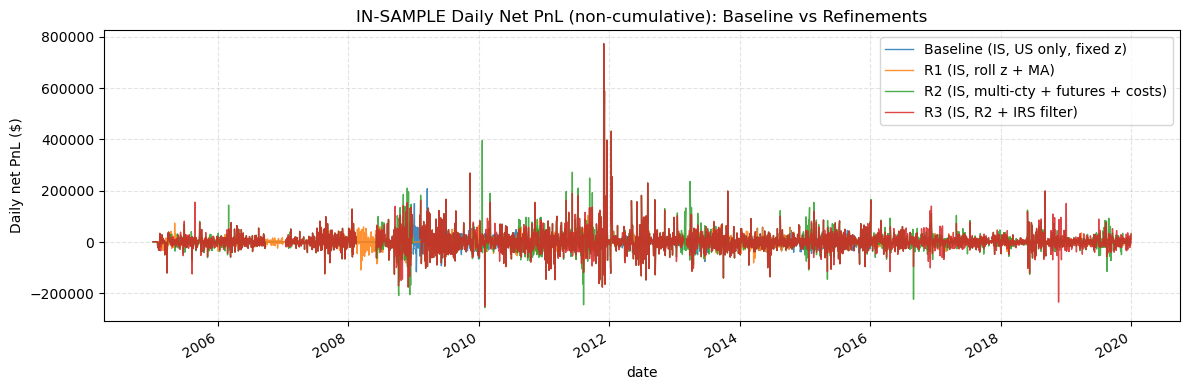

{'Baseline (IS, US only, fixed z)': 5, 'R1 (IS, roll z + MA)': 47, 'R2 (IS, multi-cty + futures + costs)': 237, 'R3 (IS, R2 + IRS filter)': 221}


In [ ]:
# Build signals (in-sample only because curves were filtered already)
sig_gov = build_signals(curve_by_cty, FLIES)
sig_irs = build_signals(irs_curve_by_cty, FLIES)
sig_gov = apply_irs_confirmation(sig_gov, sig_irs, z_col="z_roll")

US_ONLY = sorted([k for k in sig_gov.keys() if k[0] == "US"])
print("US_ONLY universe:", US_ONLY)

FULL_UNIVERSE = sorted(list(sig_gov.keys()))

results = {}

# Baseline performance - this is the same as prev ass
port0, tr0 = run_portfolio_backtest(
    curve_by_cty, sig_gov, futures_px=None,
    z_use="z_fixed",
    universe_keys=US_ONLY,
    max_positions=1,
    dv01_limit_fly=DV01_LIMIT_FLY,
    entry_z=ENTRY_Z, exit_z=EXIT_Z,
    use_futures=False, use_country_costs=False
)
results["Baseline (IS, US only, fixed z)"] = (port0, tr0)

# R1
port1, tr1 = run_portfolio_backtest(
    curve_by_cty, sig_gov, futures_px=None,
    z_use="z_roll",
    universe_keys=US_ONLY,
    max_positions=1,
    dv01_limit_fly=DV01_LIMIT_FLY,
    entry_z=ENTRY_Z, exit_z=EXIT_Z,
    use_futures=False, use_country_costs=False
)
results["R1 (IS, roll z + MA)"] = (port1, tr1)

# R2
port2, tr2 = run_portfolio_backtest(
    curve_by_cty, sig_gov, futures_px=futures_px,
    z_use="z_roll",
    universe_keys=FULL_UNIVERSE,
    max_positions=MAX_FLY_POSITIONS,
    dv01_limit_fly=DV01_LIMIT_FLY,
    entry_z=ENTRY_Z, exit_z=EXIT_Z,
    use_futures=True, use_country_costs=True
)
results["R2 (IS, multi-cty + futures + costs)"] = (port2, tr2)

# Re3
port3, tr3 = run_portfolio_backtest(
    curve_by_cty, sig_gov, futures_px=futures_px,
    z_use="z_filtered",
    universe_keys=FULL_UNIVERSE,
    max_positions=MAX_FLY_POSITIONS,
    dv01_limit_fly=DV01_LIMIT_FLY,
    entry_z=ENTRY_Z, exit_z=EXIT_Z,
    use_futures=True, use_country_costs=True
)
results["R3 (IS, R2 + IRS filter)"] = (port3, tr3)

# Non-Cum Pnl
fig, ax = plt.subplots(figsize=(12, 4))
for name, (p, _) in results.items():
    p["pnl_net"].plot(ax=ax, linewidth=1.0, alpha=0.85, label=name)
ax.set_title("IN-SAMPLE Daily Net PnL (non-cumulative): Baseline vs Refinements")
ax.set_ylabel("Daily net PnL ($)")
ax.grid(True, linestyle="--", alpha=0.35)
ax.legend()
plt.tight_layout()
plt.show()

print({k: len(v[1]) for k, v in results.items()})


## ASS 12 Meat and bone

- This has the plots and the correl analysis

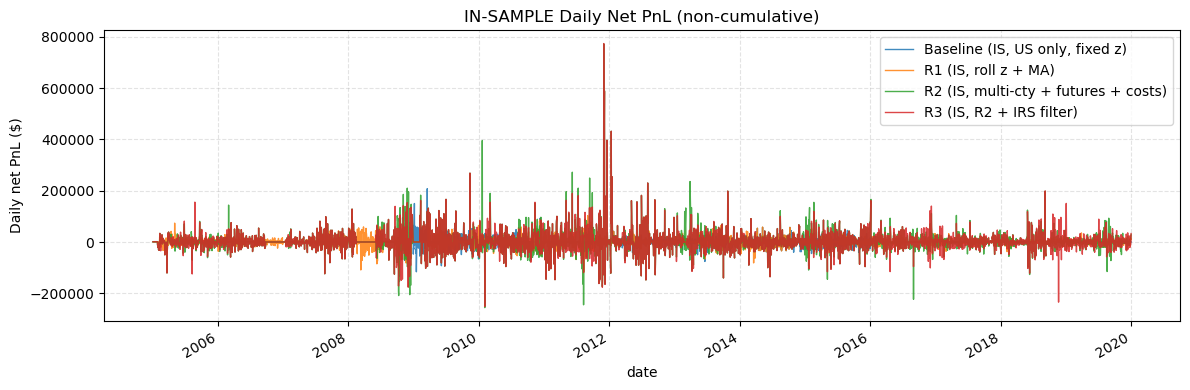

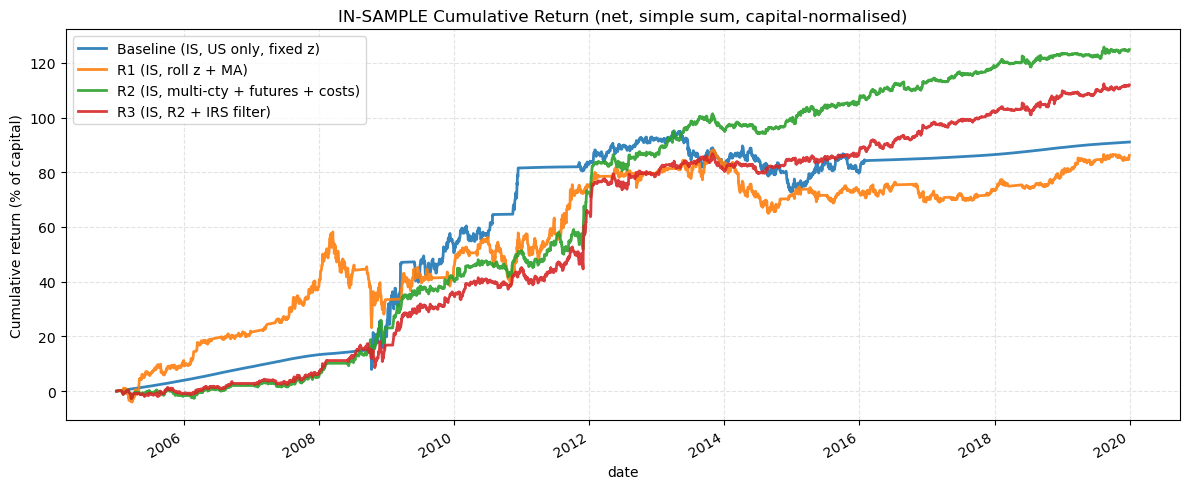

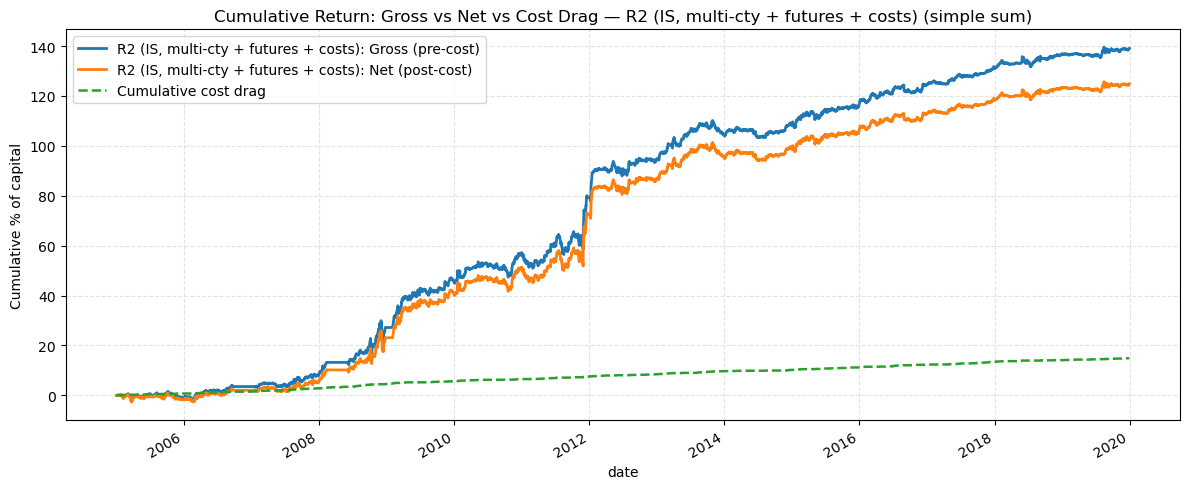

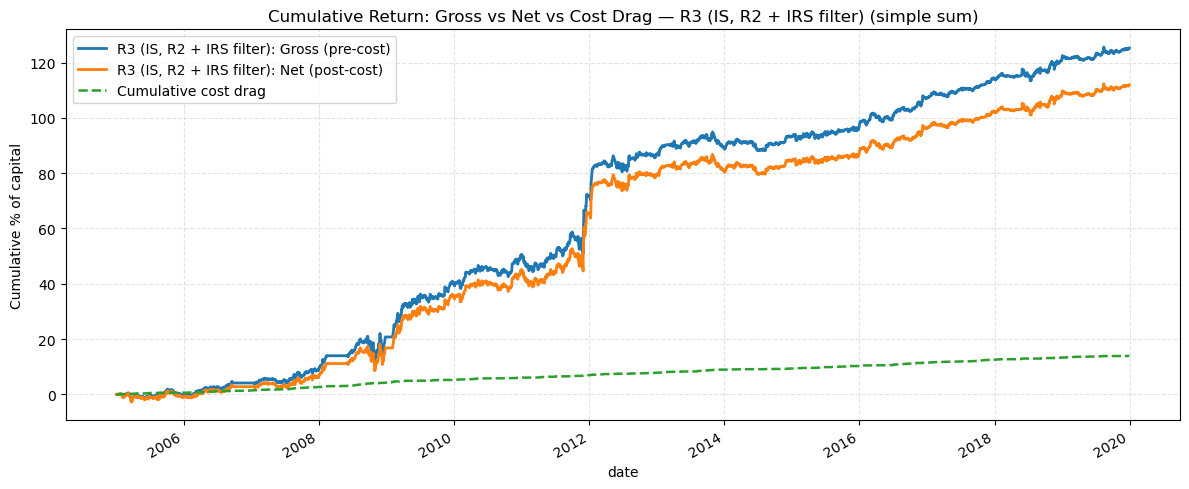

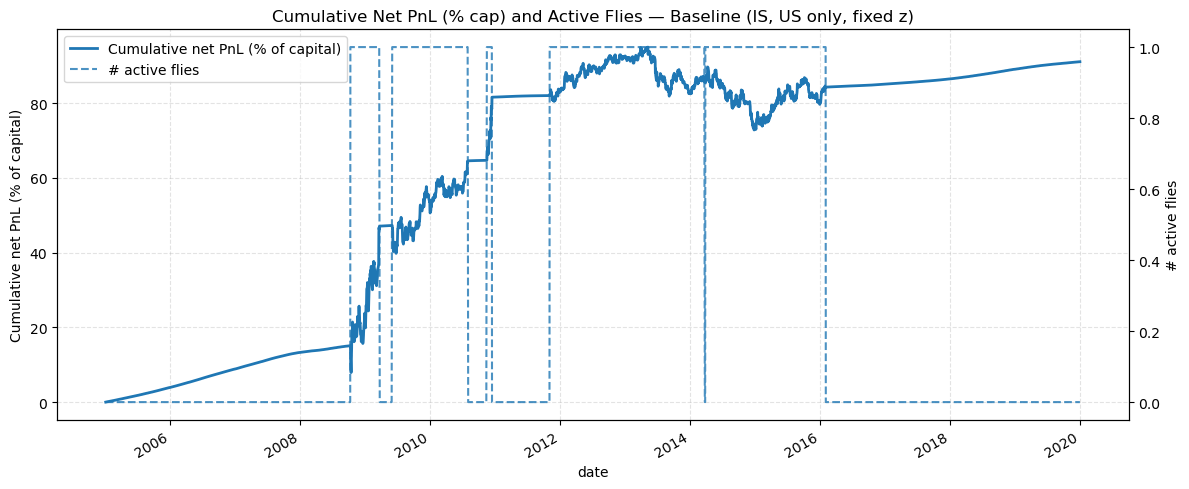

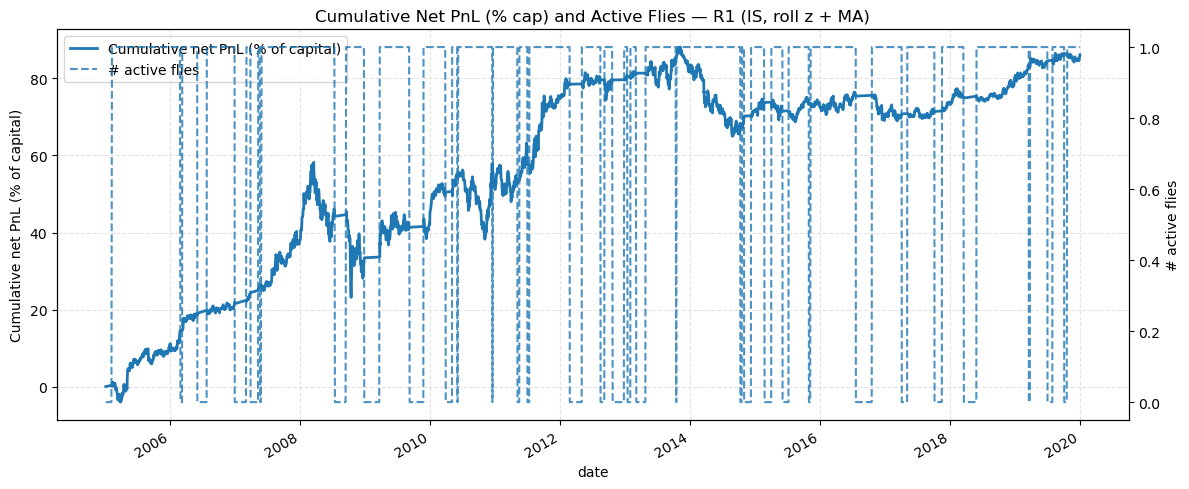

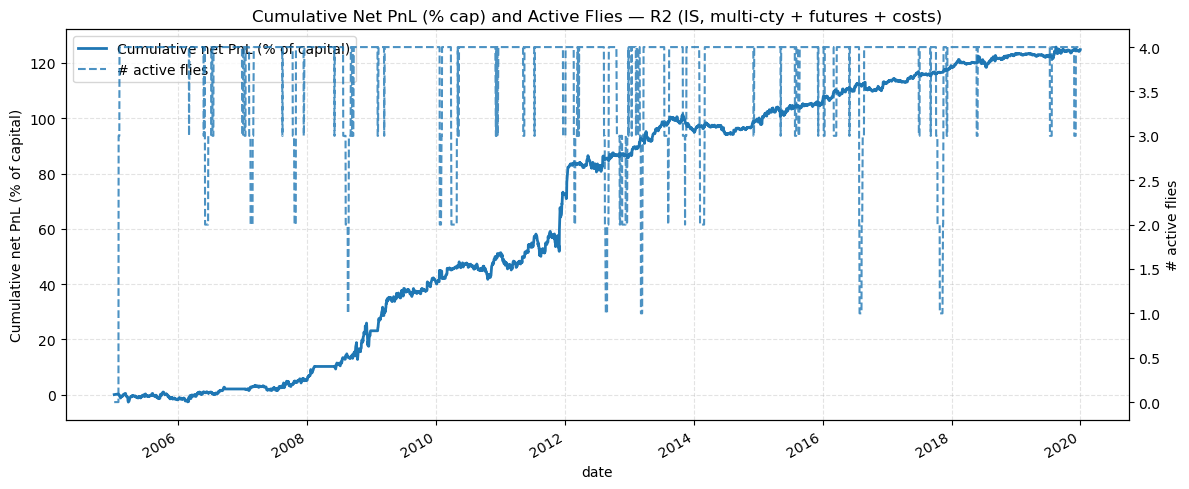

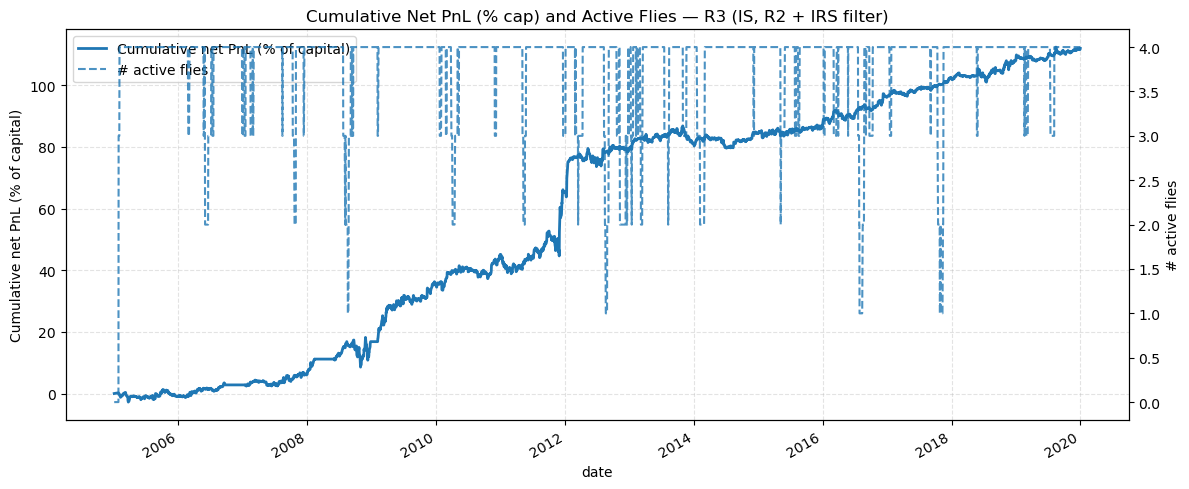

,Ann return net (%),Ann vol net (%),Sharpe net,Ann return gross (%),Ann vol gross (%),Sharpe gross,"Max DD (net, %)",Calmar (net),Sortino (net),"VaR 99% (daily, %cap)",...,"VaR 95% (daily, %cap)","ES 95% (daily, %cap)",# round-trips,Hit rate (%),Avg win ($),Avg loss ($),Avg hold (days),Trades per year,Total tx cost ($),Avg daily tx cost ($)
"Baseline (IS, US only, fixed z)",5.919,8.239,0.718,5.919,8.239,0.718,-11.368,0.521,0.659,-1.531,...,-0.722,-1.260,5.0,80.000,435533.079,-31786.670,306.600,0.325,0.0,0.000
"R1 (IS, roll z + MA)",5.600,10.309,0.543,5.600,10.309,0.543,-22.149,0.253,0.650,-1.849,...,-0.973,-1.563,47.0,74.468,98432.202,-118230.559,64.128,3.056,0.0,0.000
"R2 (IS, multi-cty + futures + costs)",8.515,6.942,1.227,9.484,6.944,1.366,-6.681,1.275,1.939,-1.069,...,-0.510,-0.856,234.0,73.077,110132.318,-62415.764,61.992,15.963,1490450.0,384.533
"R3 (IS, R2 + IRS filter)",7.657,6.632,1.155,8.569,6.633,1.292,-7.491,1.022,1.823,-1.068,...,-0.499,-0.839,217.0,72.811,108860.282,-64968.032,65.566,14.848,1395012.5,359.910


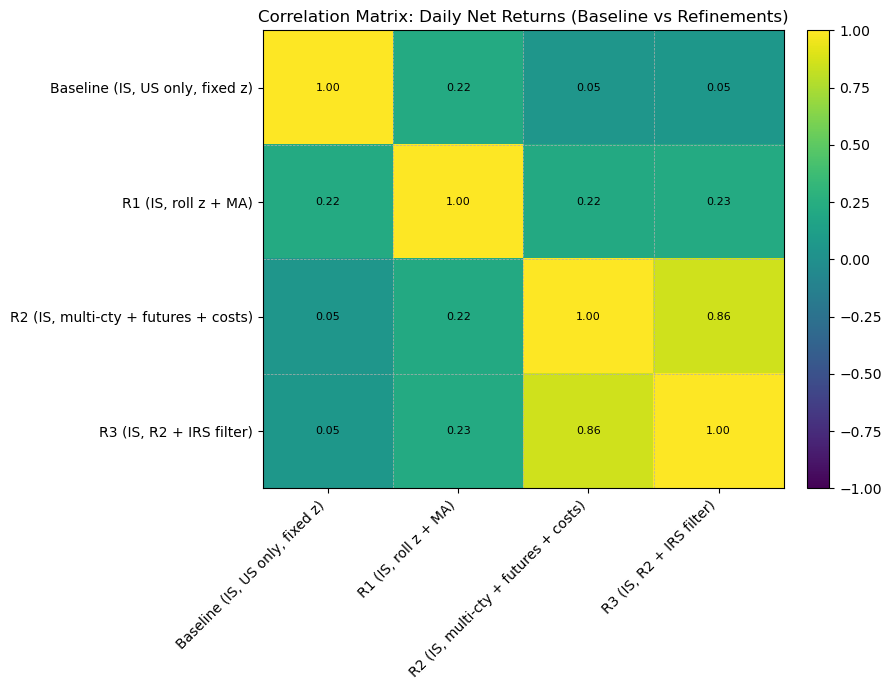

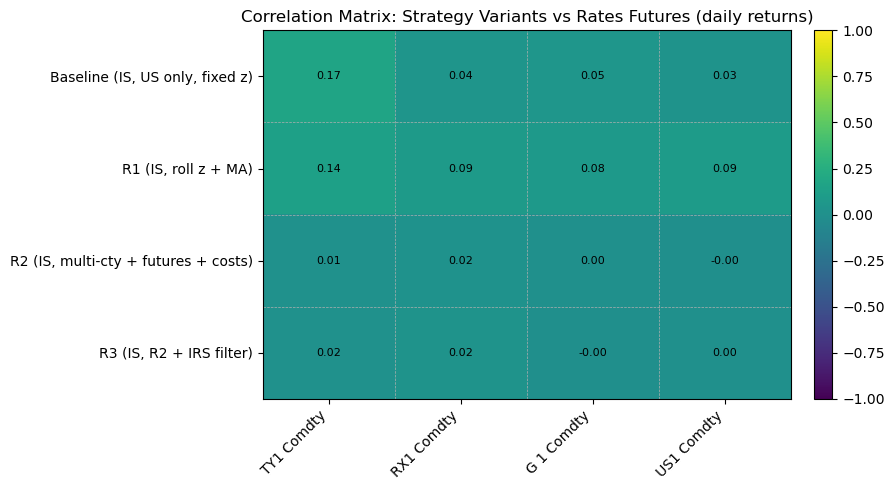

Obs count used per strategy (rows) vs futures (cols):


,TY1 Comdty,RX1 Comdty,G 1 Comdty,US1 Comdty
"Baseline (IS, US only, fixed z)",3874.0,3874.0,3874.0,3874.0
"R1 (IS, roll z + MA)",3874.0,3874.0,3874.0,3874.0
"R2 (IS, multi-cty + futures + costs)",3692.0,3692.0,3692.0,3692.0
"R3 (IS, R2 + IRS filter)",3681.0,3681.0,3681.0,3681.0


[*********************100%***********************]  9 of 9 completed


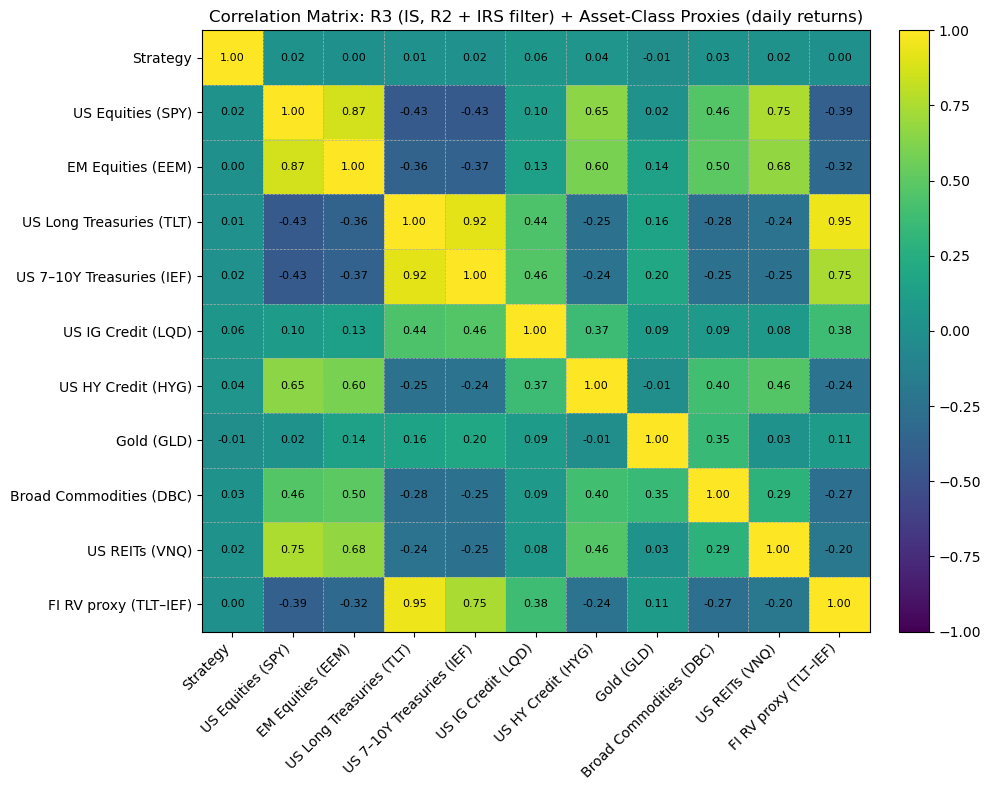

,Corr w/ Strategy
Gold (GLD),-0.0090
FI RV proxy (TLT–IEF),0.0021
EM Equities (EEM),0.0021
US Long Treasuries (TLT),0.0083
US 7–10Y Treasuries (IEF),0.0153
US REITs (VNQ),0.0192
US Equities (SPY),0.0240
Broad Commodities (DBC),0.0286
US HY Credit (HYG),0.0446
US IG Credit (LQD),0.0591


In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results_meta = {
    "Baseline (IS, US only, fixed z)": dict(max_positions=1,  has_costs=False, z_col="z_fixed"),
    "R1 (IS, roll z + MA)"           : dict(max_positions=1,  has_costs=False, z_col="z_roll"),
    "R2 (IS, multi-cty + futures + costs)": dict(max_positions=MAX_FLY_POSITIONS, has_costs=True,  z_col="z_roll"),
    "R3 (IS, R2 + IRS filter)"            : dict(max_positions=MAX_FLY_POSITIONS, has_costs=True,  z_col="z_filtered"),
}

def _capital_total(max_positions: int) -> float:
    return max_positions * DV01_LIMIT_FLY * CAPITAL_PER_DV01

def _safe_series(x: pd.Series) -> pd.Series:
    return x.replace([np.inf, -np.inf], np.nan).dropna()

def _max_drawdown_from_simple_cumret(ret_simple: pd.Series) -> float:
    """
    ret_simple = daily returns (as fraction of capital), NOT compounded.
    Equity curve for DD: 1 + cumsum(ret_simple).
    """
    r = _safe_series(ret_simple)
    if r.empty:
        return np.nan
    eq = 1.0 + r.cumsum()
    dd = eq / eq.cummax() - 1.0
    return float(dd.min())

def compute_summary_stats(port: pd.DataFrame, trades: pd.DataFrame, capital_total: float) -> pd.Series:
    out = {}
    if port is None or port.empty:
        return pd.Series(out)

    # daily returns as a % of current capital 
    ret_net   = _safe_series(port["pnl_net"]   / capital_total)
    ret_gross = _safe_series(port["pnl_gross"] / capital_total)

    def ann_stats(r: pd.Series):
        if len(r) < 2:
            return np.nan, np.nan, np.nan
        mu = r.mean()
        vol = r.std(ddof=1)
        ann_ret = mu * ANNUAL_DAYS
        ann_vol = vol * np.sqrt(ANNUAL_DAYS)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
        return float(ann_ret), float(ann_vol), float(sharpe)

    ann_ret_net, ann_vol_net, sharpe_net = ann_stats(ret_net)
    ann_ret_gross, ann_vol_gross, sharpe_gross = ann_stats(ret_gross)

    max_dd = _max_drawdown_from_simple_cumret(ret_net)
    calmar = ann_ret_net / abs(max_dd) if (not np.isnan(max_dd) and max_dd < 0) else np.nan

    downside = ret_net[ret_net < 0]
    if len(downside) >= 2:
        down_std = downside.std(ddof=1) * np.sqrt(ANNUAL_DAYS)
        sortino = ann_ret_net / down_std if down_std > 0 else np.nan
    else:
        sortino = np.nan

    def var_es(r: pd.Series, alpha=0.99):
        r = _safe_series(r)
        if len(r) < 50:
            return np.nan, np.nan
        s = np.sort(r.values)
        idx = int((1 - alpha) * len(s))
        idx = int(np.clip(idx, 0, len(s) - 1))
        var = float(s[idx])
        es = float(s[:idx + 1].mean()) if idx >= 0 else np.nan
        return var, es

    var99, es99 = var_es(ret_net, 0.99)
    var95, es95 = var_es(ret_net, 0.95)

    if trades is not None and not trades.empty:
        pnl_tr = trades["pnl"].dropna()
        wins = pnl_tr[pnl_tr > 0]
        losses = pnl_tr[pnl_tr < 0]
        hit = len(wins) / len(pnl_tr) if len(pnl_tr) else np.nan
        avg_win = wins.mean() if len(wins) else np.nan
        avg_loss = losses.mean() if len(losses) else np.nan
        avg_hold = trades["holding_days"].mean() if "holding_days" in trades.columns else np.nan
        n_trades = len(pnl_tr)

        n_years = len(ret_net) / ANNUAL_DAYS if len(ret_net) else np.nan
        turnover = n_trades / n_years if (n_years and n_years > 0) else np.nan
    else:
        hit = avg_win = avg_loss = avg_hold = np.nan
        n_trades = 0
        turnover = np.nan

    total_cost = float(port["trade_cost"].sum()) if "trade_cost" in port.columns else np.nan
    avg_daily_cost = float(port["trade_cost"].mean()) if "trade_cost" in port.columns else np.nan

    out.update({
        "Ann return net (%)": 100 * ann_ret_net,
        "Ann vol net (%)": 100 * ann_vol_net,
        "Sharpe net": sharpe_net,
        "Ann return gross (%)": 100 * ann_ret_gross,
        "Ann vol gross (%)": 100 * ann_vol_gross,
        "Sharpe gross": sharpe_gross,
        "Max DD (net, %)": 100 * max_dd,
        "Calmar (net)": calmar,
        "Sortino (net)": sortino,
        "VaR 99% (daily, %cap)": 100 * var99,
        "ES 99% (daily, %cap)": 100 * es99,
        "VaR 95% (daily, %cap)": 100 * var95,
        "ES 95% (daily, %cap)": 100 * es95,
        "# round-trips": n_trades,
        "Hit rate (%)": 100 * hit if not np.isnan(hit) else np.nan,
        "Avg win ($)": avg_win,
        "Avg loss ($)": avg_loss,
        "Avg hold (days)": avg_hold,
        "Trades per year": turnover,
        "Total tx cost ($)": total_cost,
        "Avg daily tx cost ($)": avg_daily_cost,
    })
    return pd.Series(out)

def _heatmap(ax, mat: np.ndarray, xlabels, ylabels, title: str,
             vmin=-1.0, vmax=1.0, annotate=True, fmt="{:.2f}"):
    im = ax.imshow(mat, aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_xticklabels(xlabels, rotation=45, ha="right")
    ax.set_yticklabels(ylabels)

    # Maybe make it columbia theme do we haveea a theme guys?
    ax.set_xticks(np.arange(-0.5, len(xlabels), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(ylabels), 1), minor=True)
    ax.grid(which="minor", linestyle="--", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    if annotate:
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                val = mat[i, j]
                if np.isfinite(val):
                    ax.text(j, i, fmt.format(val), ha="center", va="center", fontsize=8)
    return im

# pnl plot
fig, ax = plt.subplots(figsize=(12, 4))
for name, (p, _) in results.items():
    p["pnl_net"].fillna(0.0).plot(ax=ax, linewidth=1.0, alpha=0.85, label=name)
ax.set_title("IN-SAMPLE Daily Net PnL (non-cumulative)")
ax.set_ylabel("Daily net PnL ($)")
ax.grid(True, linestyle="--", alpha=0.35)
ax.legend()
plt.tight_layout()
plt.show()

# cum plot
fig, ax = plt.subplots(figsize=(12, 5))
for name, (p, _) in results.items():
    cap = _capital_total(results_meta[name]["max_positions"])
    daily_ret = (p["pnl_net"].fillna(0.0) / cap)
    cum_simple = daily_ret.cumsum()
    (cum_simple * 100).plot(ax=ax, linewidth=2, alpha=0.9, label=name)
ax.set_title("IN-SAMPLE Cumulative Return (net, simple sum, capital-normalised)")
ax.set_ylabel("Cumulative return (% of capital)")
ax.grid(True, linestyle="--", alpha=0.35)
ax.legend()
plt.tight_layout()
plt.show()

# Pre vs post - thi was prior feedback 
def plot_cost_drag_simple(name: str):
    p, _ = results[name]
    cap = _capital_total(results_meta[name]["max_positions"])

    cum_gross = (p["pnl_gross"].fillna(0.0) / cap).cumsum()
    cum_net   = (p["pnl_net"].fillna(0.0)   / cap).cumsum()
    cum_cost  = (p["trade_cost"].fillna(0.0) / cap).cumsum()

    fig, ax = plt.subplots(figsize=(12, 5))
    (cum_gross * 100).plot(ax=ax, linewidth=2, label=f"{name}: Gross (pre-cost)")
    (cum_net   * 100).plot(ax=ax, linewidth=2, label=f"{name}: Net (post-cost)")
    (cum_cost  * 100).plot(ax=ax, linewidth=1.8, linestyle="--", label="Cumulative cost drag")
    ax.set_title(f"Cumulative Return: Gross vs Net vs Cost Drag — {name} (simple sum)")
    ax.set_ylabel("Cumulative % of capital")
    ax.grid(True, linestyle="--", alpha=0.35)
    ax.legend()
    plt.tight_layout()
    plt.show()

for nm in results:
    if results_meta[nm]["has_costs"]:
        plot_cost_drag_simple(nm)

# Add the active flies so we can see when active when not
def plot_active_overlay_pct(name: str):
    p, _ = results[name]
    cap = _capital_total(results_meta[name]["max_positions"])

    fig, ax1 = plt.subplots(figsize=(12, 5))
    cum_net_pct = (p["pnl_net"].fillna(0.0).cumsum() / cap) * 100
    cum_net_pct.plot(ax=ax1, linewidth=2, label="Cumulative net PnL (% of capital)")
    ax1.set_title(f"Cumulative Net PnL (% cap) and Active Flies — {name}")
    ax1.set_ylabel("Cumulative net PnL (% of capital)")
    ax1.grid(True, linestyle="--", alpha=0.35)

    ax2 = ax1.twinx()
    p["num_active_positions"].fillna(0).plot(ax=ax2, linestyle="--", alpha=0.8, label="# active flies")
    ax2.set_ylabel("# active flies")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")
    plt.tight_layout()
    plt.show()

for nm in results:
    plot_active_overlay_pct(nm)

# Call table form before
stats_rows = []
for name, (p, tr) in results.items():
    cap = _capital_total(results_meta[name]["max_positions"])
    s = compute_summary_stats(p, tr, cap)
    s.name = name
    stats_rows.append(s)

stats_table = pd.DataFrame(stats_rows)
display(stats_table.round(3))

# Corr matrix
ret_panel = {}
for name, (p, _) in results.items():
    cap = _capital_total(results_meta[name]["max_positions"])
    ret_panel[name] = (p["pnl_net"] / cap)

ret_panel = pd.DataFrame(ret_panel).replace([np.inf, -np.inf], np.nan).dropna(how="any")
corr_variants = ret_panel.corr()

fig, ax = plt.subplots(figsize=(9, 7))
im = _heatmap(
    ax,
    corr_variants.values,
    xlabels=corr_variants.columns.tolist(),
    ylabels=corr_variants.index.tolist(),
    title="Correlation Matrix: Daily Net Returns (Baseline vs Refinements)",
    vmin=-1.0, vmax=1.0, annotate=True
)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Corr matrix 
bench_cols = [c for c in ["TY1 Comdty", "RX1 Comdty", "G 1 Comdty", "US1 Comdty"] if c in futures_px.columns]
if bench_cols:
    fut_ret = futures_px[bench_cols].pct_change()

    corr_vs_fut = pd.DataFrame(index=list(results.keys()), columns=bench_cols, dtype=float)
    nobs_vs_fut = pd.DataFrame(index=list(results.keys()), columns=bench_cols, dtype=float)

    for name, (p, _) in results.items():
        cap = _capital_total(results_meta[name]["max_positions"])
        strat = (p["pnl_net"] / cap).rename("Strategy")
        merged = pd.concat([strat, fut_ret], axis=1).replace([np.inf, -np.inf], np.nan).dropna()

        if merged.shape[0] < 50:
            continue

        c = merged.corr().loc["Strategy", bench_cols]
        corr_vs_fut.loc[name, bench_cols] = c.values
        nobs_vs_fut.loc[name, bench_cols] = merged.shape[0]

    fig, ax = plt.subplots(figsize=(9, 5))
    im = _heatmap(
        ax,
        corr_vs_fut.values.astype(float),
        xlabels=bench_cols,
        ylabels=corr_vs_fut.index.tolist(),
        title="Correlation Matrix: Strategy Variants vs Rates Futures (daily returns)",
        vmin=-1.0, vmax=1.0, annotate=True
    )
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    print("Obs count used per strategy (rows) vs futures (cols):")
    display(nobs_vs_fut)
else:
    print("No benchmark futures columns found in futures_px for correlation matrix.")

# Use yfinance to get the data - 
try:
    import yfinance as yf

    yahoo_tickers = {
        "SPY": "US Equities (SPY)",
        "EEM": "EM Equities (EEM)",
        "TLT": "US Long Treasuries (TLT)",
        "IEF": "US 7–10Y Treasuries (IEF)",
        "LQD": "US IG Credit (LQD)",
        "HYG": "US HY Credit (HYG)",
        "GLD": "Gold (GLD)",
        "DBC": "Broad Commodities (DBC)",
        "VNQ": "US REITs (VNQ)",
    }

    pick_name = "R3 (IS, R2 + IRS filter)"
    cap = _capital_total(results_meta[pick_name]["max_positions"])
    strategy_ret = (results[pick_name][0]["pnl_net"] / cap).dropna().rename("Strategy")

    start = strategy_ret.index.min().strftime("%Y-%m-%d")
    end   = strategy_ret.index.max().strftime("%Y-%m-%d")

    raw = yf.download(list(yahoo_tickers.keys()), start=start, end=end, group_by="ticker", auto_adjust=False)

    # Extract Adj Close if possible
    if isinstance(raw.columns, pd.MultiIndex):
        prices = {}
        for tic in yahoo_tickers.keys():
            if tic in raw.columns.get_level_values(0):
                sub = raw[tic]
                col = "Adj Close" if "Adj Close" in sub.columns else ("Close" if "Close" in sub.columns else None)
                if col:
                    prices[tic] = sub[col]
        prices = pd.DataFrame(prices)
    else:
        col = "Adj Close" if "Adj Close" in raw.columns else ("Close" if "Close" in raw.columns else None)
        prices = raw[[col]].rename(columns={col: list(yahoo_tickers.keys())[0]})

    asset_ret = prices.pct_change()

    combined = pd.concat([strategy_ret, asset_ret], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    combined = combined.rename(columns={k: v for k, v in yahoo_tickers.items() if k in combined.columns})

    # just in case it dies later on other machines
    if "US Long Treasuries (TLT)" in combined.columns and "US 7–10Y Treasuries (IEF)" in combined.columns:
        combined["FI RV proxy (TLT–IEF)"] = combined["US Long Treasuries (TLT)"] - combined["US 7–10Y Treasuries (IEF)"]

    corr = combined.corr()

    fig, ax = plt.subplots(figsize=(10, 8))
    im = _heatmap(
        ax,
        corr.values,
        xlabels=corr.columns.tolist(),
        ylabels=corr.index.tolist(),
        title=f"Correlation Matrix: {pick_name} + Asset-Class Proxies (daily returns)",
        vmin=-1.0, vmax=1.0, annotate=True
    )
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    
    strat_corr = corr.loc["Strategy"].drop("Strategy").sort_values()
    display(strat_corr.to_frame("Corr w/ Strategy").round(4))

except Exception as e:
    print("Yahoo proxy block skipped (yfinance/internet issue). Error:", repr(e))


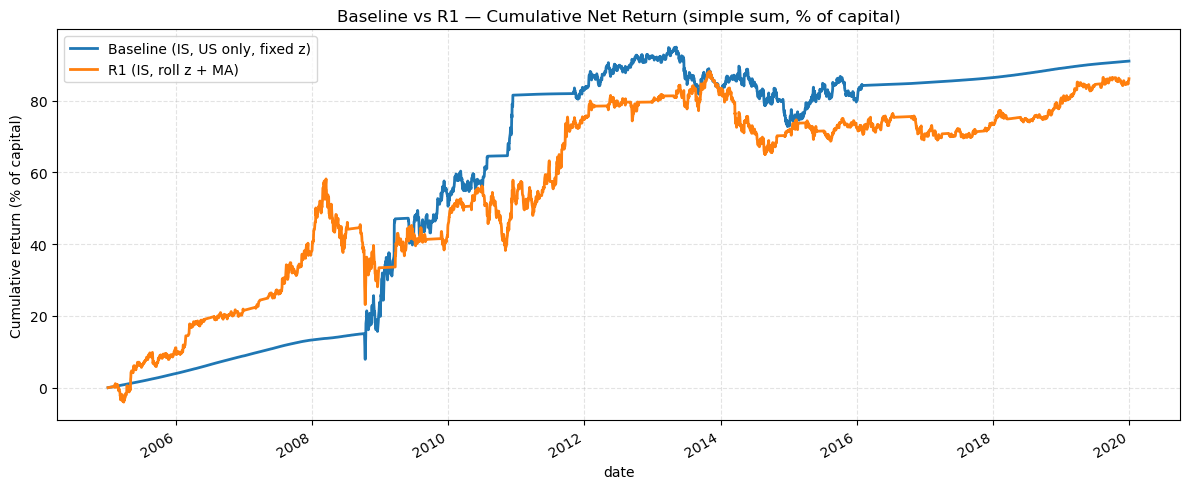

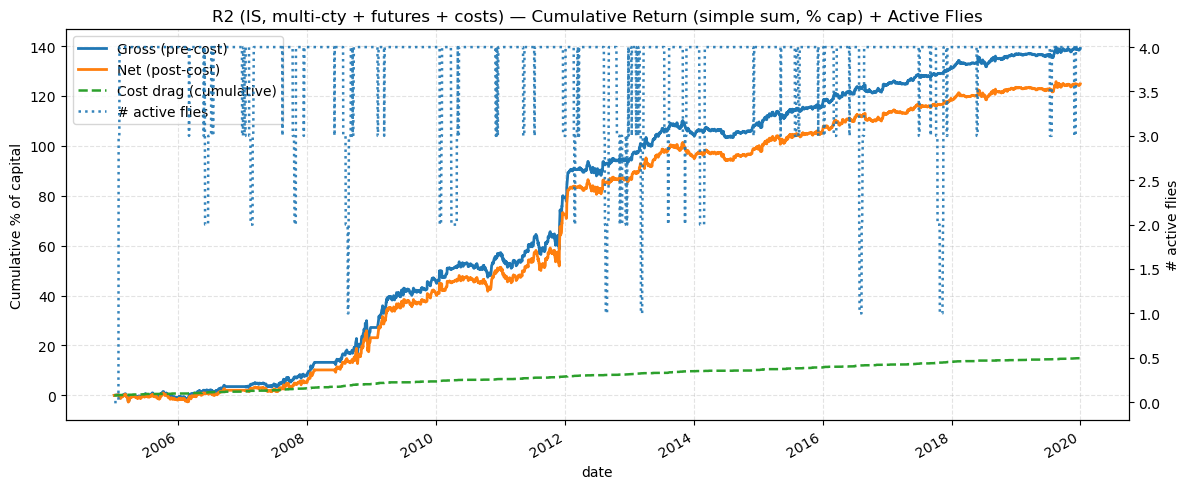

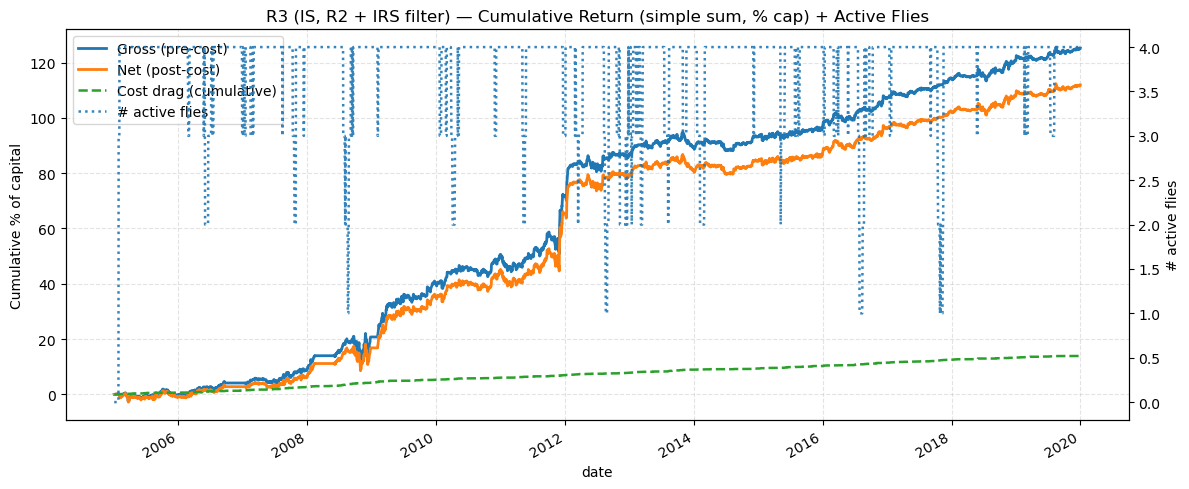

In [ ]:
def _cap_for(name: str) -> float:
    return _capital_total(results_meta[name]["max_positions"])

def _cum_simple_pct(p: pd.DataFrame, cap: float, col: str) -> pd.Series:
    return (p[col].fillna(0.0).cumsum() / cap) * 100.0

# Ass12 req for the baseline v r1
base_name = "Baseline (IS, US only, fixed z)"
r1_name   = "R1 (IS, roll z + MA)"

p0, _ = results[base_name]
p1, _ = results[r1_name]

cap0 = _cap_for(base_name)
cap1 = _cap_for(r1_name)

fig, ax = plt.subplots(figsize=(12, 5))
_cum_simple_pct(p0, cap0, "pnl_net").plot(ax=ax, linewidth=2, label=base_name)
_cum_simple_pct(p1, cap1, "pnl_net").plot(ax=ax, linewidth=2, label=r1_name)

ax.set_title("Baseline vs R1 — Cumulative Net Return (simple sum, % of capital)")
ax.set_ylabel("Cumulative return (% of capital)")
ax.grid(True, linestyle="--", alpha=0.35)
ax.legend()
plt.tight_layout()
plt.show()


# the newer imrpovements running hte strates
def plot_cost_drag_and_flies(name: str):
    p, _ = results[name]
    cap = _cap_for(name)

    cum_gross = _cum_simple_pct(p, cap, "pnl_gross")
    cum_net   = _cum_simple_pct(p, cap, "pnl_net")
    cum_cost  = (p["trade_cost"].fillna(0.0).cumsum() / cap) * 100.0

    fig, ax1 = plt.subplots(figsize=(12, 5))

    cum_gross.plot(ax=ax1, linewidth=2, label="Gross (pre-cost)")
    cum_net.plot(ax=ax1, linewidth=2, label="Net (post-cost)")
    cum_cost.plot(ax=ax1, linewidth=1.8, linestyle="--", label="Cost drag (cumulative)")

    ax1.set_title(f"{name} — Cumulative Return (simple sum, % cap) + Active Flies")
    ax1.set_ylabel("Cumulative % of capital")
    ax1.grid(True, linestyle="--", alpha=0.35)

    ax2 = ax1.twinx()
    p["num_active_positions"].fillna(0).plot(
        ax=ax2, linestyle=":", linewidth=1.8, alpha=0.9, label="# active flies"
    )
    ax2.set_ylabel("# active flies")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    plt.tight_layout()
    plt.show()

plot_cost_drag_and_flies("R2 (IS, multi-cty + futures + costs)")
plot_cost_drag_and_flies("R3 (IS, R2 + IRS filter)")

## OOS Run for 2020 onwards

Requested OOS window: 2020-01-01 → END
Aligned FULL range: 2005-01-03 → 2025-10-01 | N = 5365
Aligned OOS  range : 2020-01-02 → 2025-10-01 | N = 1489
OOS # trades (R3): 71


,Ann return net (%),Ann vol net (%),Sharpe net,Ann return gross (%),Ann vol gross (%),Sharpe gross,"Max DD (net, %)",Calmar (net),Sortino (net),"VaR 99% (daily, %cap)",...,"VaR 95% (daily, %cap)","ES 95% (daily, %cap)",# round-trips,Hit rate (%),Avg win ($),Avg loss ($),Avg hold (days),Trades per year,Total tx cost ($),Avg daily tx cost ($)
"R3 (OOS, R2 + IRS filter)",3.309,4.931,0.671,4.198,4.915,0.854,-4.859,0.681,0.971,-0.937,...,-0.453,-0.707,71.0,71.831,79467.782,-71003.611,79.239,12.016,525112.5,352.661


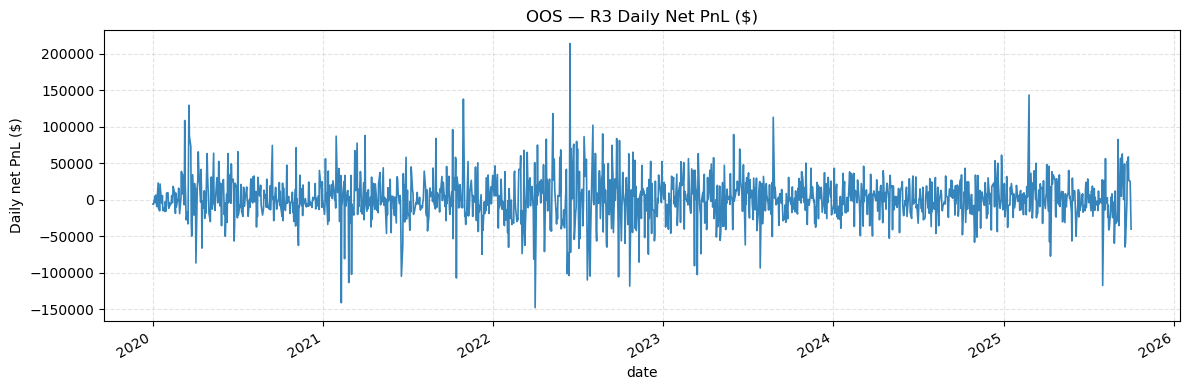

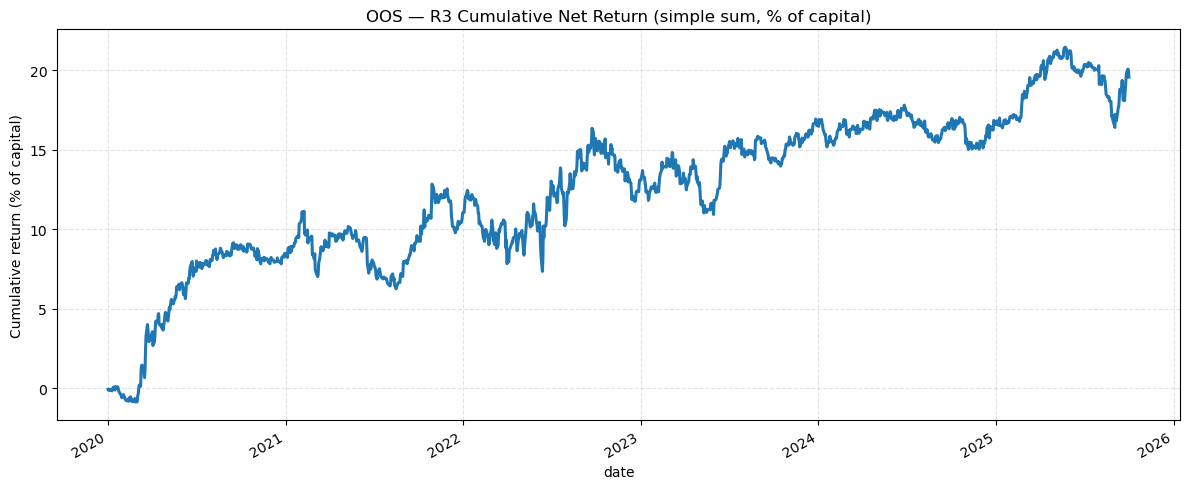

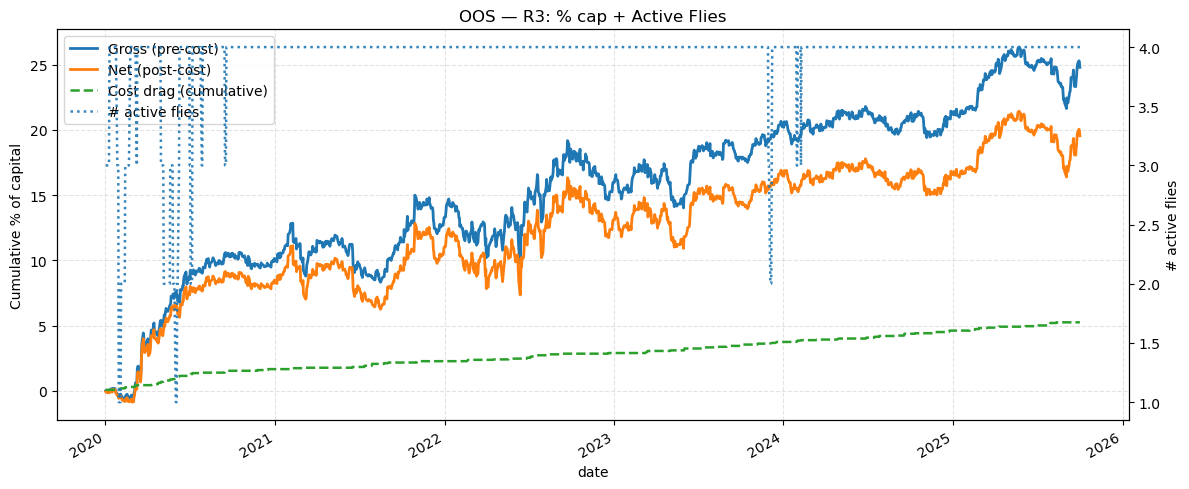

In [ ]:
IS_R3_KEY = "R3 (IS, R2 + IRS filter)"
if "IN_SAMPLE_END" in globals():
    IS_END = pd.Timestamp(IN_SAMPLE_END)
elif "results" in globals() and (IS_R3_KEY in results) and (results[IS_R3_KEY][0] is not None) and (not results[IS_R3_KEY][0].empty):
    IS_END = pd.Timestamp(results[IS_R3_KEY][0].index.max())
else:
    raise RuntimeError(
        "lol no go. go back and fix it ."
    )

OOS_START = IS_END + pd.Timedelta(days=1)
OOS_END   = None  # waht was last dae again 
print("Requested OOS window:", OOS_START.date(), "→", ("END" if OOS_END is None else pd.Timestamp(OOS_END).date()))



# load the panels
yields_full  = load_sovereign_yields()
futs_full    = load_futures_prices()
irs_full     = load_irs_yields()

curve_by_cty_full = {cty: build_curve_df_for_country(yields_full, cty, CURVE_COLS, TENOR_MAP) for cty in CURVE_COLS}
irs_by_cty_full   = {cty: build_curve_df_for_country(irs_full,    cty, IRS_CURVE_COLS, IRS_TENOR_MAP) for cty in IRS_CURVE_COLS}

# Align the daes for the OOS
common = None
for _, df in curve_by_cty_full.items():
    common = df.index if common is None else common.intersection(df.index)
common = common.intersection(futs_full.index)
for _, df in irs_by_cty_full.items():
    common = common.intersection(df.index)
common = common.sort_values()

for cty in curve_by_cty_full:
    curve_by_cty_full[cty] = curve_by_cty_full[cty].reindex(common).ffill()
for cty in irs_by_cty_full:
    irs_by_cty_full[cty] = irs_by_cty_full[cty].reindex(common).ffill()
futs_full = futs_full.reindex(common).ffill()

# Cut it up 
oos_end_eff = common.max() if OOS_END is None else pd.Timestamp(OOS_END)
oos_dates = common[(common >= OOS_START) & (common <= oos_end_eff)]

if len(oos_dates) == 0:
    raise RuntimeError(
        f"No OOS dates available after {OOS_START.date()} in the aligned dataset. common.max()={common.max().date()}"
    )

print("Aligned FULL range:", common.min().date(), "→", common.max().date(), "| N =", len(common))
print("Aligned OOS  range :", oos_dates.min().date(), "→", oos_dates.max().date(), "| N =", len(oos_dates))

# build the signals on the full OOS datset
sig_gov_full = build_signals(curve_by_cty_full, FLIES)
sig_irs_full = build_signals(irs_by_cty_full,   FLIES)
sig_gov_full = apply_irs_confirmation(sig_gov_full, sig_irs_full, z_col="z_roll")  

def slice_signals(sig_by_key: dict, dates: pd.DatetimeIndex) -> dict:
    out = {}
    for k, obj in sig_by_key.items():
        out[k] = {"tenors": obj["tenors"], "sig_df": obj["sig_df"].reindex(dates)}
    return out

curve_by_cty_oos = {cty: df.reindex(oos_dates).ffill() for cty, df in curve_by_cty_full.items()}
futs_oos         = futs_full.reindex(oos_dates).ffill()
sig_gov_oos      = slice_signals(sig_gov_full, oos_dates)

# run the r3 oos backtest
FULL_UNIVERSE = sorted(list(sig_gov_oos.keys()))
p3, t3 = run_portfolio_backtest(
    curve_by_cty_oos, sig_gov_oos, futures_px=futs_oos,
    z_use="z_filtered",
    universe_keys=FULL_UNIVERSE,
    max_positions=MAX_FLY_POSITIONS,
    dv01_limit_fly=DV01_LIMIT_FLY,
    entry_z=ENTRY_Z, exit_z=EXIT_Z,
    use_futures=True, use_country_costs=True
)

print("OOS # trades (R3):", (0 if t3 is None else len(t3)))

# Overall stats
cap_oos = MAX_FLY_POSITIONS * DV01_LIMIT_FLY * CAPITAL_PER_DV01
stats_oos_r3 = compute_summary_stats(p3, t3, cap_oos)
display(pd.DataFrame([stats_oos_r3], index=["R3 (OOS, R2 + IRS filter)"]).round(3))

# Plot 1 - PnL
fig, ax = plt.subplots(figsize=(12, 4))
p3["pnl_net"].fillna(0.0).plot(ax=ax, linewidth=1.2, alpha=0.9)
ax.set_title("OOS — R3 Daily Net PnL ($)")
ax.set_ylabel("Daily net PnL ($)")
ax.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()

# Cum returns
fig, ax = plt.subplots(figsize=(12, 5))
_cum_simple_pct(p3, cap_oos, "pnl_net").plot(ax=ax, linewidth=2.2)
ax.set_title("OOS — R3 Cumulative Net Return (simple sum, % of capital)")
ax.set_ylabel("Cumulative return (% of capital)")
ax.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()

# Gross vs ex transaction costs
cum_gross = _cum_simple_pct(p3, cap_oos, "pnl_gross")
cum_net   = _cum_simple_pct(p3, cap_oos, "pnl_net")
cum_cost  = (p3["trade_cost"].fillna(0.0).cumsum() / cap_oos) * 100.0

fig, ax1 = plt.subplots(figsize=(12, 5))
cum_gross.plot(ax=ax1, linewidth=2, label="Gross (pre-cost)")
cum_net.plot(ax=ax1, linewidth=2, label="Net (post-cost)")
cum_cost.plot(ax=ax1, linewidth=1.8, linestyle="--", label="Cost drag (cumulative)")
ax1.set_title("OOS — R3: % cap + Active Flies")
ax1.set_ylabel("Cumulative % of capital")
ax1.grid(True, linestyle="--", alpha=0.35)

ax2 = ax1.twinx()
p3["num_active_positions"].fillna(0).plot(ax=ax2, linestyle=":", linewidth=1.8, alpha=0.9, label="# active flies")
ax2.set_ylabel("# active flies")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")
plt.tight_layout()
plt.show()